In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import os


# Spill uyarılarını kapatmak için
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# Görsel Parametreleri
img_size = (224, 224)
batch_size = 64

In [16]:
# Dosya Konumları
base_orig = "CitrusFruit/Original"
base_aug  = "CitrusFruit/Augmentation"

train_orig_dir = f"{base_orig}/Train"
val_orig_dir   = f"{base_orig}/Val"
test_orig_dir  = f"{base_orig}/Test"

train_aug_dir = f"{base_aug}/Train-A"
val_aug_dir   = f"{base_aug}/Val-A"
test_aug_dir  = f"{base_aug}/Test-A"

# Ham Veriler
train_orig = tf.keras.utils.image_dataset_from_directory(
    train_orig_dir, seed=42, image_size=img_size, batch_size=batch_size, label_mode="categorical"
)
val_orig = tf.keras.utils.image_dataset_from_directory(
    val_orig_dir, seed=42, image_size=img_size, batch_size=batch_size, label_mode="categorical"
)
test_orig = tf.keras.utils.image_dataset_from_directory(
    test_orig_dir, seed=42, image_size=img_size, batch_size=batch_size, label_mode="categorical"
)

# Augmente Edilmiş Veriler
train_aug = tf.keras.utils.image_dataset_from_directory(
    train_aug_dir, seed=42, image_size=img_size, batch_size=batch_size, label_mode="categorical"
)
val_aug = tf.keras.utils.image_dataset_from_directory(
    val_aug_dir, seed=42, image_size=img_size, batch_size=batch_size, label_mode="categorical"
)
test_aug = tf.keras.utils.image_dataset_from_directory(
    test_aug_dir, seed=42, image_size=img_size, batch_size=batch_size, label_mode="categorical"
)

# Verilerin birleştirilmesi
train_ds = train_orig.concatenate(train_aug)
val_ds   = val_orig.concatenate(val_aug)
test_ds  = test_orig.concatenate(test_aug)

Found 966 files belonging to 4 classes.
Found 275 files belonging to 4 classes.
Found 138 files belonging to 4 classes.
Found 5796 files belonging to 4 classes.
Found 1650 files belonging to 4 classes.
Found 138 files belonging to 4 classes.


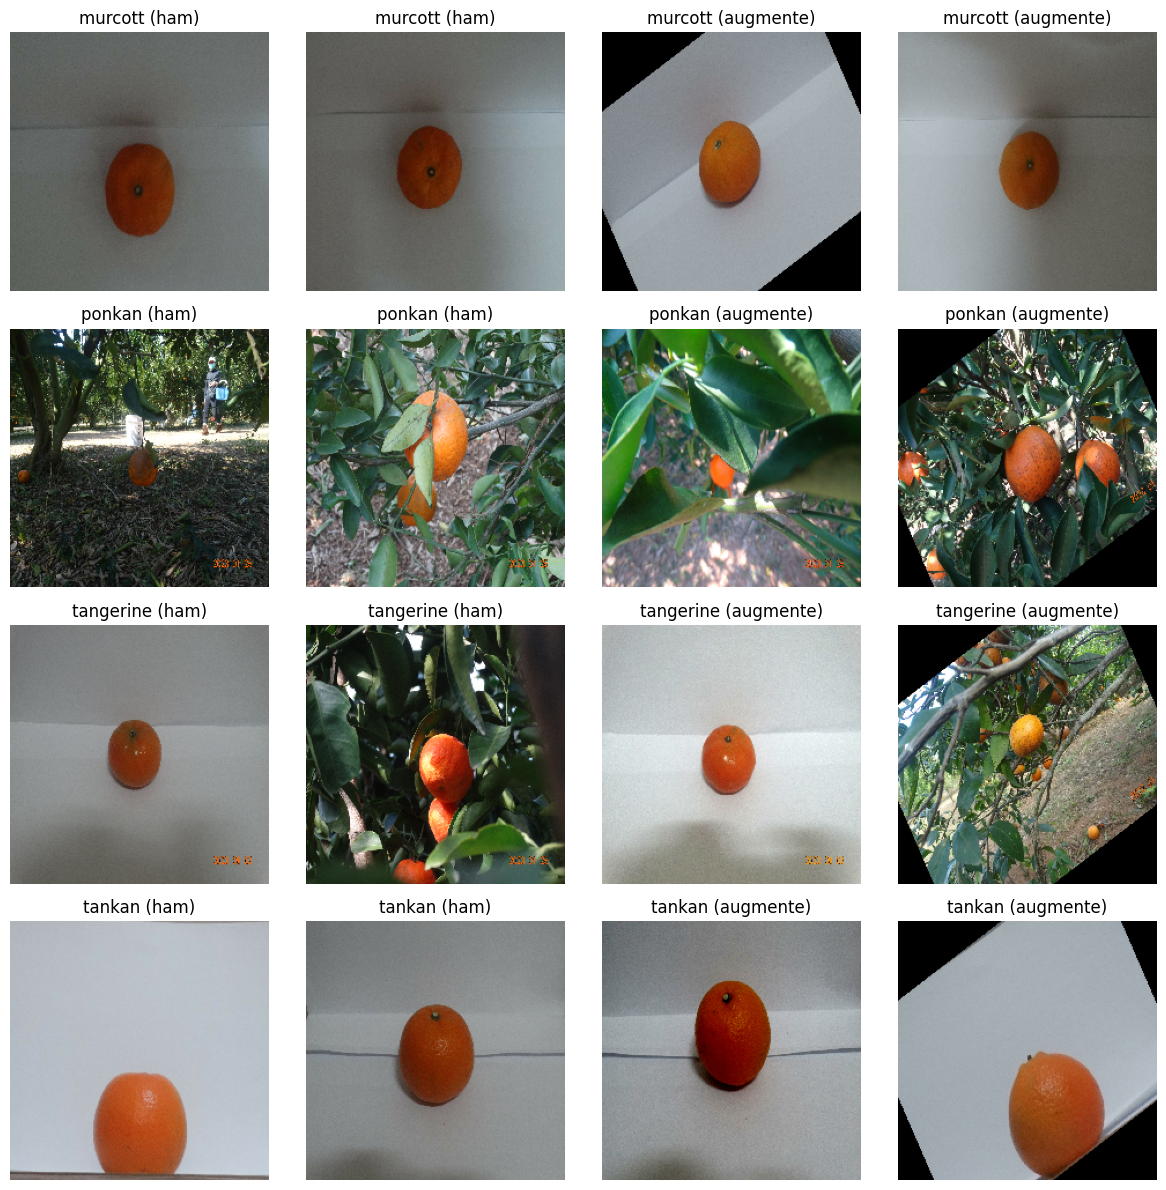

In [17]:
# Sınıf isimleri
class_names = train_orig.class_names

# Her sınıf için resim listelerini oluştur
orig_images = {i: [] for i in range(len(class_names))}
aug_images  = {i: [] for i in range(len(class_names))}

# Orijinal verilerden her sınıfa 2 resim al
for image, label in train_orig.unbatch():
    idx = np.argmax(label.numpy())
    if len(orig_images[idx]) < 2:
        orig_images[idx].append(image.numpy().astype("uint8")) # Aralığı 0-255 yapıyoruz
    if all(len(v) >= 2 for v in orig_images.values()):
        break

# Augment edilmiş verilerden her sınıfa 2 resim al
for image, label in train_aug.unbatch():
    idx = np.argmax(label.numpy())
    if len(aug_images[idx]) < 2:
        aug_images[idx].append(image.numpy().astype("uint8")) # Aralığı 0-255 yapıyoruz
    if all(len(v) >= 2 for v in aug_images.values()):
        break

# Görselleştirme
fig, axes = plt.subplots(len(class_names), 4, figsize=(12, 3 * len(class_names)))
for i, cname in enumerate(class_names):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(orig_images[i][j])
        ax.set_title(f"{cname} (ham)")
        ax.axis("off")
    for j in range(2):
        ax = axes[i, j + 2]
        ax.imshow(aug_images[i][j])
        ax.set_title(f"{cname} (augmente)")
        ax.axis("off")

plt.tight_layout()
plt.show()

2025-05-29 18:27:08.962867: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


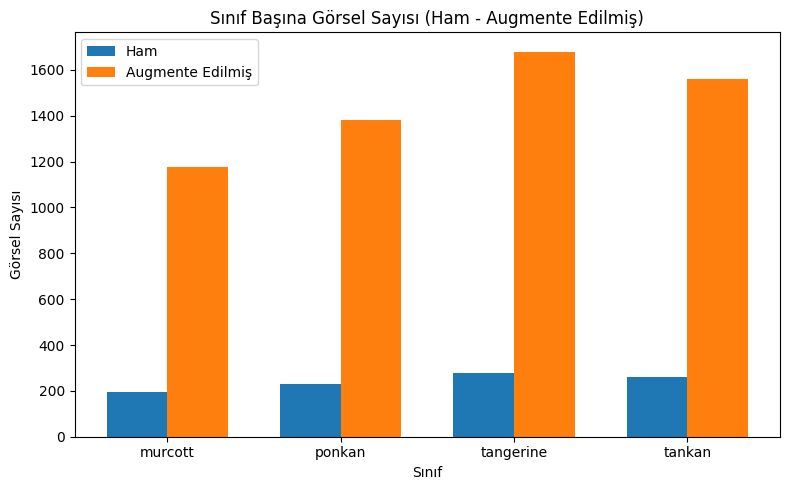

In [18]:
# Sınıflar için dictionary oluşturuluyor
orig_counts = {c: 0 for c in class_names}
aug_counts  = {c: 0 for c in class_names}

# Orijinal kümeden sınıf sayıları alınıyor
for img, label in train_orig.unbatch():
    idx = np.argmax(label.numpy())
    orig_counts[class_names[idx]] += 1

# Augmente edilmiş kümeden sınıf sayıları alınıyor
for img, label in train_aug.unbatch():
    idx = np.argmax(label.numpy())
    aug_counts[class_names[idx]] += 1

# Veriler
x = np.arange(len(class_names))
width = 0.35
orig_vals = [orig_counts[c] for c in class_names]
aug_vals  = [aug_counts[c]  for c in class_names]

# Grafik çizimi
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, orig_vals, width, label="Ham")
ax.bar(x + width/2, aug_vals, width, label="Augmente Edilmiş")

ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylabel("Görsel Sayısı")
ax.set_xlabel("Sınıf")
ax.set_title("Sınıf Başına Görsel Sayısı (Ham - Augmente Edilmiş)")
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
# Model yükleniyor
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Transfer Learning için base donduruluyor

# Modelin uç kısmı oluşturuluyor
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(4, activation="softmax")  # Çıktı = Sınıf Sayısı
])

In [24]:
# Model Derleniyor
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Model Özeti
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
# Erken durdurma tanımlanıyor
early_stop = EarlyStopping(
    monitor="val_loss",         
    patience=5,                 
    restore_best_weights=True, 
    verbose=1
)

In [26]:
# Model Eğitiliyor
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 278ms/step - accuracy: 0.6868 - loss: 0.7909 - val_accuracy: 0.8603 - val_loss: 0.3805
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.8573 - loss: 0.3732 - val_accuracy: 0.9018 - val_loss: 0.3028
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.8835 - loss: 0.3008 - val_accuracy: 0.9060 - val_loss: 0.2765
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.9014 - loss: 0.2559 - val_accuracy: 0.9122 - val_loss: 0.2591
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.9167 - loss: 0.2105 - val_accuracy: 0.9049 - val_loss: 0.2622
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - accuracy: 0.9275 - loss: 0.1908 - val_accuracy: 0.8982 - val_loss: 0.2879
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 222ms/step - accuracy: 0.9304 - loss: 0.1759 - val_accuracy: 0.9023 - val_loss: 0.2740
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.9358 - loss: 0

In [27]:
# Test Performansı
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.2f}")

2/6 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.9531 - loss: 0.1749

2025-05-29 19:25:44.530603: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 8 bytes spill stores, 8 bytes spill loads

2025-05-29 19:25:44.629889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 12 bytes spill stores, 12 bytes spill loads

2025-05-29 19:25:44.790493: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 112 bytes spill stores, 112 bytes spill loads

2025-05-29 19:25:44.797544: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195_0', 184 bytes spill stores, 520 bytes spill loads

2025-05-29 19:25:44.885549: I extern

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 866ms/step - accuracy: 0.9417 - loss: 0.2086
Test Accuracy: 0.93


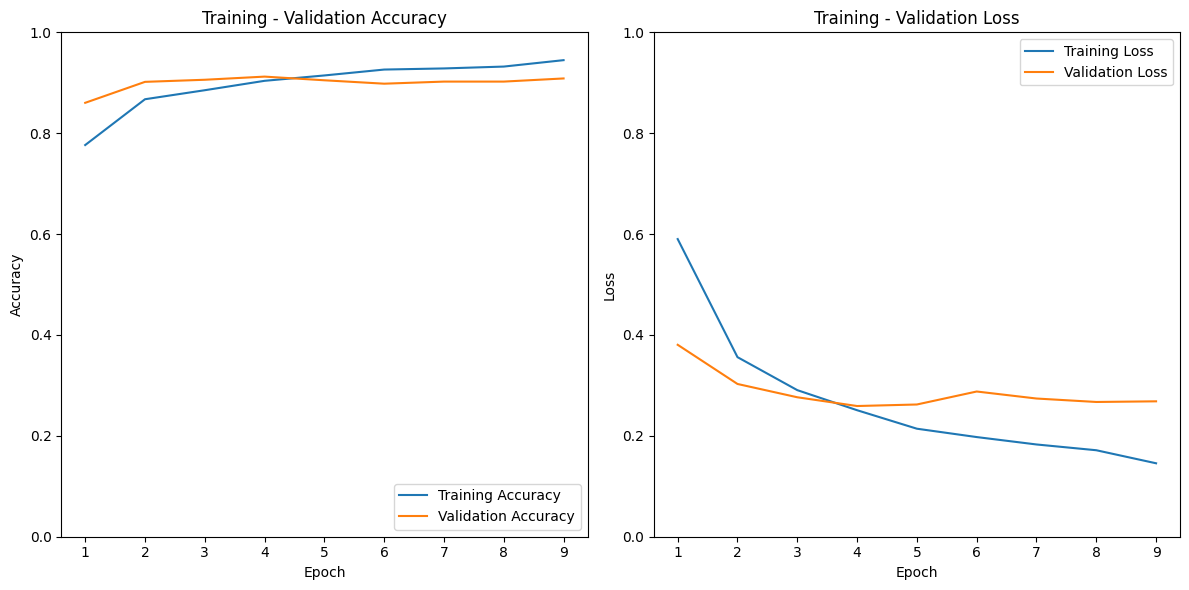

In [28]:
# Train ve Validation Grafikleri
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Training - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # 0 - 1
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Training - Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1)  # 0 - 1
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

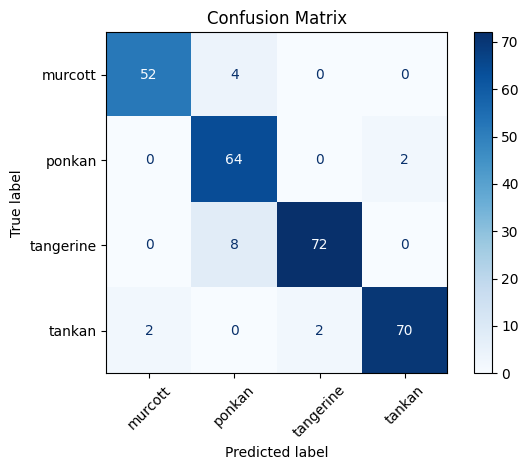

Classification Report:

              precision    recall  f1-score   support

     murcott       0.96      0.93      0.95        56
      ponkan       0.84      0.97      0.90        66
   tangerine       0.97      0.90      0.94        80
      tankan       0.97      0.95      0.96        74

    accuracy                           0.93       276
   macro avg       0.94      0.94      0.94       276
weighted avg       0.94      0.93      0.94       276



In [31]:
# Model tahmini ve gerçek değerler alınıyor
y_true, y_pred = [], []
for images, labels in test_ds:  
    preds = model.predict(images, verbose=0) # Batch olarak tahmin ediliyor
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix görselleştiriliyor
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Sınıflandırma Raporu Oluşturuluyor
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))